In [1]:
%matplotlib inline

In [29]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import optimize
import seaborn as sn

import pycollocation

from ipywidgets import interact, interactive
from IPython.display import clear_output, display, HTML

I based the following on lecture notes on [investment with adjustment costs](http://eml.berkeley.edu/~webfac/gourinchas/e202a_f14/Notes_Investment_pog.pdf) from UC Berkeley.

## Non-renewable energy sector

Sector combines capital, $K_{NR}$, and fossil fuels, $F$, to produce energy $E_{NR}$ via...

$$ E\big(F(t), K_{NR}(t)\big). \tag{1} $$


### Profits

Sector profits are...

$$ \Pi_{NR}(t) = p_E E\big(F(t), K_{NR}(t)\big) - p_F F(t) - p_K\big(1 + C(I_{NR}, K_{NR})\big)I_{NR}(t) \tag{2} $$

...where $p_E$, $p_F$, and $p_K$ are, respectively, the prices of energy, fossil fuels, and capital goods; finally, $C(I_{NR}(t), K_{NR}(t))$ represents the *percentage* increase in costs required to install one unit of capital.

Note that this formulation implies that percentage adjustment costs are *convex* in the level of investment; since adjustment costs depend on the ratio of investment to installed capital, percentage adjustment costs scale up with the level of capital. 

### Objective

Want to solve...

$$ \max_{I_{NR}(t), F(t)} \int_0^{\infty} e^{-rt} \Pi_{NR}(t) dt \tag{4} $$

...subject to the following constraint...

$$ \dot{K}_{NR}(t) = I_{NR}(t) - \delta K_{NR}(t). \tag{5} $$

### Solution

Start by setting up the current value Hamiltonian...

$$ H(F(t), I(t), \lambda(t)) \equiv p_E E\big(F(t), K_{NR}(t)\big) - p_F F(t) - p_K\bigg(1 + C\big(I_{NR}(t), K_{NR}(t)\big)\bigg)I_{NR}(t) + \lambda(t)\big[I_{NR}(t) - \delta K_{NR}(t)\big] \tag{6} $$ 

...first-order optimality conditions are...

\begin{align}
    \frac{\partial H}{\partial F} = 0 \implies& E_F\big(F(t), K_{NR}(t)\big) = \frac{p_F}{p_E} \tag{7} \\
    \frac{\partial H}{\partial I} = 0 \implies& - p_K - p_K\bigg[C\big(I_{NR}(t), K_{NR}(t)\big) + C_I\big(I_{NR}(t), K_{NR}(t)\big)I_{NR}(t)\bigg] + \lambda(t) = 0 \\
    & 1 + C\big(I_{NR}(t), K_{NR}(t)\big) + C_I\big(I_{NR}(t), K_{NR}(t)\big)I_{NR}(t) = \frac{\lambda(t)}{p_K} \tag{8} \\
    \frac{\partial H}{\partial K} = -\big(\dot{\lambda}(t) - r\lambda(t)\big) \implies& p_E E_K\big(F(t), K_{NR}(t)\big) - p_K C_K\big(I_{NR}(t), K_{NR}(t)\big)I_{NR}(t) - \delta\lambda(t) = -\big(\dot{\lambda}(t) - r\lambda(t)\big) \\
    &P_E E_K\big(F(t), K_{NR}(t)\big) - p_KC_K\big(I_{NR}(t), K_{NR}(t)\big)I_{NR}(t) - \delta\lambda(t) = -\dot{\lambda}(t) + r\lambda(t) \\
    &(r + \delta)\frac{\lambda(t)}{p_K} + C_K\big(I_{NR}(t), K_{NR}(t)\big)I_{NR}(t) - \frac{p_E}{p_K}E_K\big(F(t), K_{NR}(t)\big) = \frac{\dot{\lambda}(t)}{p_K} \tag{9}
\end{align}

...assumptions on functions $E\big(F(t), K_{NR}(t)\big)$ and $C\big(I(t), K_{NR}(t)\big)$ are sufficient to guarantee that there exist functions $\Phi$ and $\Psi$ such that equations 7 and 8 can be written as...

\begin{align}
    F(t) =& \Phi\big(K_{NR}(t); p_E, p_F\big) \tag{10} \\
    I_{NR}(t) =& \Psi\bigg(\frac{\lambda(t)}{p_K}, K_{NR}(t)\bigg) \tag{11}
\end{align}

... substituting equations 10 and 11 into equation 9 and then defining Tobin's *marginal* $q$ as follows...

$$ q(t) = \frac{\lambda(t)}{P_K} \implies \dot{q}(t) = \frac{\dot{\lambda}(t)}{P_K} \tag{13}$$

...yields a differential equation describing the evolution of $q$...

$$ \dot{q}(t) = (r + \delta)q(t) + C_K\bigg(\Psi\big(q(t), K_{NR}(t)\big), K_{NR}(t)\bigg)\Psi\big(q(t), K_{NR}(t)\big) - \frac{p_E}{p_K}E_K\bigg(\Phi\big(K_{NR}(t); p_E, p_F\big), K_{NR}(t)\bigg). \tag{14} $$

Need a differential equation describing the evolution of capital stock: just use the constraint!

\begin{align}
    \dot{K}_{NR}(t) =& I_{NR}(t) - \delta K_{NR}(t) \\
    =& \Psi\big(q(t), K_{NR}(t)\big) - \delta K_{NR}(t) \tag{15}
\end{align}

Equations 14 and 15 describe a system of differential equations describing the evolution of $K_{NR}(t)$ and $q(t)$.  To complete the model we need to define boundary conditions. Capital stock is predetermined so we take the initial condition as given: $K_{NR}(0) = K_0$.  Tobin's $q$ is a jump variable whose value is pinned down in steady state.

In [3]:
def output(F, K, A, alpha, beta, sigma=1, **params):
    """Non-renewable sector energy production."""
    rho = (sigma - 1) / sigma
    if rho == 0:
        energy = A * F**alpha * K**beta
    else:
        energy = (alpha * F**rho + beta * K**rho)**(1 / rho)
    return energy


def marginal_product_capital(F, K, A, alpha, beta, sigma=1, **params):
    """Increase in non-renewable sector energy production generated by an additional unit of physical capital."""
    rho = (sigma - 1) / sigma
    if rho == 0:
        marginal_product =  A * beta * F**alpha * K**(beta - 1)
    else:
        marginal_product = beta * K**(rho-1) * (alpha * F**rho + beta * K**rho)**((1 / rho) - 1)
    return marginal_product


def marginal_product_fossil_fuel(F, K, A, alpha, beta, sigma=1, **params):
    """Increase in non-renewable sector energy production generated by an additional unit of fossil fuel."""
    rho = (sigma - 1) / sigma
    if rho == 0:
        marginal_product = A * alpha * F**(alpha - 1) * K**beta
    else:
        marginal_product = alpha * F**(rho-1) * (alpha * F**rho + beta * K**rho)**((1 / rho) - 1)
    return marginal_product
    

### Adjustment costs

I use the following formulation of *percentage* adjustment costs...

$$ C\big(I_{NR}(t), K_{NR}(t)\big)\bigg) = \frac{\phi}{2}\bigg(\frac{I_{NR}(t)}{K_{NR}(t)}\bigg)^2 \tag{15} $$

...note the following important features:

1. Convex in the level of investment
2. Homogenous of degree zero in investment and capital

In [4]:
def adjustment_cost(I, K, phi, **params):
    """Percentage costs of adjusting stock of physical capital."""
    return (phi / 2) * (I / K)**2


def marginal_adjustment_cost_capital(I, K, phi, **params):
    """Adjustment cost of adding/removing an additional unit of capital."""
    return -phi * (I / K)**2 * (1 / K)


def marginal_adjustment_cost_investment(I, K, phi, **params):
    """Adjustment cost of adding/removing an additional unit of investment."""
    return phi * (I / K) * (1 / K)


In [5]:
def investment_demand_schedule(q, K, phi, **params):
    I = ((2 / 3) * (q - 1) * (1 / phi))**0.5 * K
    return I


def _first_order_condition_investment(I, q, K, phi, **params):
    out = 1 + adjustment_cost(I, K, phi) + marginal_adjustment_cost_investment(I, K, phi) * I - q
    return out

In [6]:
def fossil_fuel_demand_schedule(q, K, A, alpha, beta, energy_price, fossil_fuel_price, sigma=1.0, **params):
    relative_price = energy_price / fossil_fuel_price
    rho = (sigma - 1) / sigma
    if rho == 0:
        F = (A * alpha * relative_price * K**beta)**(1 / (1 - alpha))
    else:
        raise NotImplementedError
    return F


def _first_order_condition_fossil_fuel(F, q, K, A, alpha, beta, energy_price, fossil_fuel_price, sigma, **params):
    relative_price = fossil_fuel_price / fossil_fuel_price
    return marginal_product_fossil_fuel(F, K, A, alpha, beta, sigma) - relative_price

In [7]:
def equation_motion_q(t, q, K, capital_price, delta, energy_price, r, **params):
    F = fossil_fuel_demand_schedule(q, K, energy_price=energy_price, **params)
    I = investment_demand_schedule(q, K, **params)
    relative_price = energy_price / capital_price
    q_dot = ((r + delta) * q + marginal_adjustment_cost_capital(I, K, **params) * I -
             relative_price * marginal_product_capital(F, K, **params))
    return q_dot


def equation_motion_capital(t, q, K, delta, **params):
    I = investment_demand_schedule(q, K, **params)
    K_dot = I - delta * K
    return K_dot


In [8]:
def investment_adjustment_costs_model(t, q, K, **params):
    rhs = [equation_motion_q(t, q, K, **params), 
           equation_motion_capital(t, q, K, **params)]
    return rhs

In [9]:
def steady_state_q(delta, phi, **params):
    """Steady state value for tobins's q"""
    return 1 + (3 / 2) * delta**2 * phi


def steady_state_capital(**params):
    """Steady state capital is indeterminate with constant returns to scale."""
    q_ss = steady_state_q(**params)
    F = lambda K: equation_motion_q(np.inf, q_ss, K, **params)
    kss, full_results = optimize.brentq(F, 1e-15, 1e15, full_output=True, disp=True)
    return kss if full_results.converged else full_results


In what follows I use the following formulation for the adjustment costs function.

$$ C(I_{NR}(t), K_{NR}(t)) = \frac{\phi}{2}\bigg(\frac{I_{NR}(t)}{K_{NR}(t)}\bigg)^2 \tag{3} $$

In [10]:
def initial_condition(t, q, K, K0, **params):
    return [K - K0]


def terminal_condition(t, q, K, **params):
    """In steady state"""
    return [q - steady_state_q(**params)]

In [46]:
def initial_mesh(t, T, num, problem):
    
    # compute equilibrium values
    q_ss = steady_state_q(**problem.params)
    capital_ss = steady_state_capital(**problem.params)
    
    # create the mesh for capital
    ts = np.linspace(t, T, num)
    K0 = problem.params['K0']
    Ks = capital_ss - (capital_ss - K0) * np.exp(-ts)

    # create the mesh for q
    q0 = 0.5 * (1 + q_ss) if K0 > capital_ss else 1.1 * q_ss
    qs = q_ss - (q_ss - q0) * np.exp(-ts)

    return ts, qs, Ks

In [60]:
def solve_model(A=1, K0=1, alpha=0.55, beta=0.33, capital_price=1.0, delta=0.04,
                energy_price=1.0, fossil_fuel_price=0.85, phi=0.2, r=0.09, sigma=1.0):
    
    params = {'A': A, 'K0': K0, 'alpha': alpha, 'beta': beta, 'capital_price': capital_price,
              'delta': delta, 'energy_price': energy_price, 'fossil_fuel_price': fossil_fuel_price,
              'phi': phi, 'r': r, 'sigma': sigma}

    bvp = pycollocation.problems.TwoPointBVP(bcs_lower=initial_condition,
                                             bcs_upper=terminal_condition,
                                             number_bcs_lower=1,
                                             number_odes=2,
                                             params=params,
                                             rhs=investment_adjustment_costs_model,
                                             )
    
    polynomial_basis = pycollocation.basis_functions.PolynomialBasis()
    solver = pycollocation.solvers.Solver(polynomial_basis)

    boundary_points = (0, 50)
    ts, qs, Ks = initial_mesh(*boundary_points, num=1000, problem=bvp)

    basis_kwargs = {'kind': 'Chebyshev', 'domain': boundary_points, 'degree': 35}
    K_poly = polynomial_basis.fit(ts, Ks, **basis_kwargs)
    q_poly = polynomial_basis.fit(ts, qs, **basis_kwargs)
    initial_coefs = np.hstack([q_poly.coef, K_poly.coef])
    nodes = polynomial_basis.roots(**basis_kwargs)

    solution = solver.solve(basis_kwargs, boundary_points, initial_coefs, nodes, bvp)
    
    q_solution, capital_solution = solution.evaluate_solution(ts)

    fig, axes = plt.subplots(4, 1, figsize=(8, 16))
    
    axes[0].plot(ts, q_solution, label=r'$q$')
    axes[0].set_xlabel(r'$t$, time', fontsize=25, family='serif')
    axes[0].set_title(r"Tobin's $q$", fontsize=25, family='serif')
    axes[0].legend()
    
    axes[1].plot(ts, capital_solution, label=r'$K$')
    axes[1].set_xlabel(r'$t$, time', fontsize=25, family='serif')
    axes[1].set_title(r"Capital stock, $K$", fontsize=25, family='serif')
    axes[1].legend()
    
    # plot residuals
    q_resids, capital_resids = solution.normalize_residuals(ts)
    
    axes[2].plot(ts, np.abs(q_resids), label=r'$q$')
    axes[2].plot(ts, np.abs(capital_resids), label=r'$K$')
    axes[2].set_xlabel(r'$K$', fontsize=25)
    axes[2].set_ylim(1e-16, 1.0)
    axes[2].set_yscale('log')
    axes[2].set_title("Normalized absolute residuals", fontsize=25, family='serif')
    axes[2].legend()
    
    axes[3].plot(capital_solution, q_solution)
    axes[3].set_xlabel(r'$K$', fontsize=25)
    axes[3].set_ylabel(r'$q$', fontsize=25, rotation='horizontal')
    
    fig.tight_layout()

    plt.show()


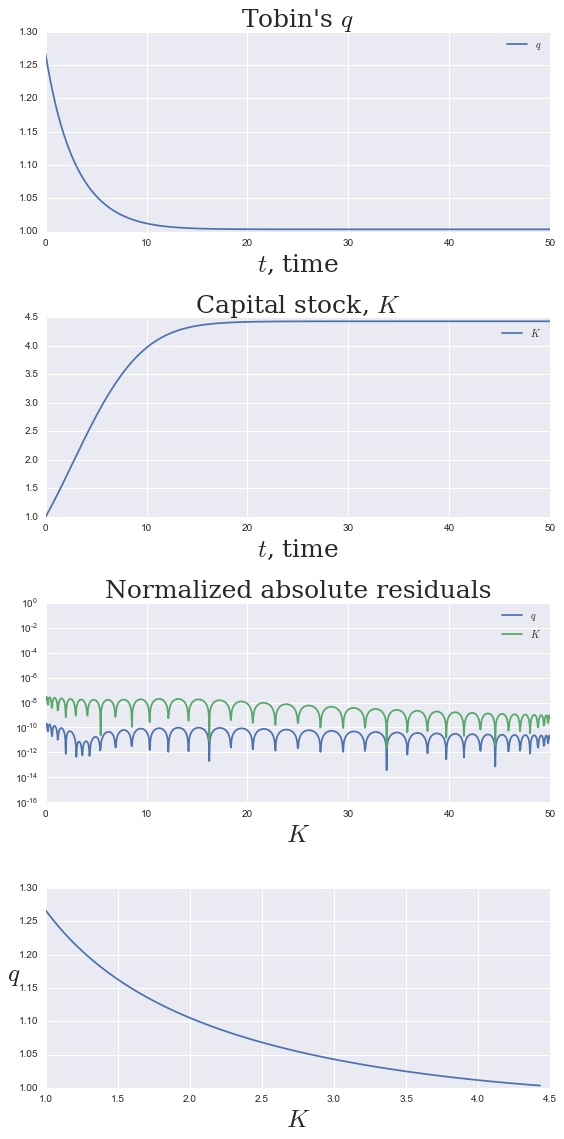

In [61]:
w = interactive(solve_model, alpha=(0, 1, 0.01), beta=(0, 1, 0.01), phi=(0.0, 10.0, 0.1), r=(0.0, 1.0, 0.01))
display(w)